
### Exoplanet Binary Classifier Notebook
### Loads `Train_k2pandc.csv`, builds a preprocessing + model pipeline,
### handles class imbalance with SMOTE, runs a small randomized hyperparameter search,
### evaluates the model, and saves the final pipeline as `model.pkl`.
### **Notes**
### - Target column: `disposition`
### - Binary mapping: dispositions that contain 'CONFIRMED', 'CANDID' or 'PC' (case-insensitive) are mapped to 1 (exoplanet).
###   Change the `is_positive_disposition()` function if you'd like another mapping.
### - Final artifact: `model.pkl` (contains preprocessing + sampler + classifier).

In [77]:
### 0) Install required packages (run once)
%pip install -q scikit-learn imbalanced-learn joblib pandas numpy matplotlib seaborn xgboost


### 1) Imports

import os
import re
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, precision_recall_curve, auc
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

Note: you may need to restart the kernel to use updated packages.


In [78]:
DATA_PATH = "Train_k2pandc.csv"
assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}"

df = pd.read_csv(DATA_PATH)
print("Dataset loaded. Shape:", df.shape)
df.head()

Dataset loaded. Shape: (3204, 94)


pl_name        hostname  default_flag     disposition  \
0  EPIC 211590050.01  EPIC 211590050             1       CANDIDATE   
1  EPIC 211600389.01  EPIC 211600389             1  FALSE POSITIVE   
2  EPIC 211600632.01  EPIC 211600632             1  FALSE POSITIVE   
3  EPIC 211604981.01  EPIC 211604981             1  FALSE POSITIVE   
4  EPIC 211606790.01  EPIC 211606790             0       CANDIDATE   

                         disp_refname  sy_snum  sy_pnum discoverymethod  \
0  Castro-Gonz&aacute;lez et al. 2022        1        0         Transit   
1                      Yu et al. 2018        1        0         Transit   
2                      Yu et al. 2018        1        0         Transit   
3                      Yu et al. 2018        1        0         Transit   
4                   Kruse et al. 2019        1        0         Transit   

   disc_year disc_facility  ... sy_vmagerr2  sy_kmag sy_kmagerr1  sy_kmagerr2  \
0       2022            K2  ...      -0.172   11.958       0.020       -0.020   
1       2018            K2  ...      -0.172   12.885       0.024       -0.024   
2       2018            K2  ...         NaN   14.142       0.076       -0.076   
3       2018            K2  ...      -0.069   11.531       0.018       -0.018   
4       2018            K2  ...      -0.103   10.398       0.025       -0.025   

   sy_gaiamag  sy_gaiamagerr1  sy_gaiamagerr2   rowupdate  pl_pubdate  \
0     13.3081        0.000210       -0.000210  2022-04-18     2022-01   
1     14.0604        0.006177       -0.006177  2019-02-26     2018-07   
2     19.2896        0.008025       -0.008025  2019-02-26     2018-07   
3     12.6528        0.000193       -0.000193  2019-02-26     2018-07   
4     12.0575        0.000170       -0.000170  2018-02-15     2018-03   

   releasedate  
0   2022-04-18  
1   2019-02-26  
2   2019-02-26  
3   2019-02-26  
4   2018-02-15  

[5 rows x 94 columns]

###  3) Inspect `disposition` target and create binary label
### Below shows the distinct values in `disposition` and map to binary 0/1.
### The mapping below treats dispositions containing `CONFIRMED`, `CANDID` or `PC` (case-insensitive) as positive (1).


In [79]:
if 'disposition' not in df.columns:
    raise KeyError("Column 'disposition' not found in CSV. Please check the file.")

print("Unique dispositions and counts:")
print(df['disposition'].value_counts(dropna=False))

# Define mapping function (adjust here if you prefer different mapping)
def is_positive_disposition(val):
    if pd.isna(val):
        return 0
    s = str(val).upper()
    # treat common positive labels as exoplanet:
    if "CONFIRMED" in s or "CANDID" in s or s == "PC" or "PLANET CANDIDATE" in s:
        return 1
    # otherwise negative (FALSE POSITIVE, NOT PLANET, etc)
    return 0

# Create binary target
df['target'] = df['disposition'].apply(is_positive_disposition)
print("\nBinary target distribution:")
print(df['target'].value_counts())

Unique dispositions and counts:
disposition
CONFIRMED         2269
CANDIDATE          739
FALSE POSITIVE     174
REFUTED             22
Name: count, dtype: int64

Binary target distribution:
target
1    3008
0     196
Name: count, dtype: int64


### 4) Basic EDA & feature selection

### - drop obviously useless columns (IDs, names, timestamps) heuristically,
### - automatically detect numeric and categorical columns,
### - leave the rest to the preprocessing pipeline.
### You can adjust columns_to_drop below if you want to force include/exclude fields.
### Heuristic drop candidates (common ID columns in exoplanet datasets)


In [80]:
possible_id_keywords = ['id', 'name', 'kepid', 'ticid', 'kepoi_name', 'kepoi', 'objid', 'targetid']
cols_lower = [c.lower() for c in df.columns]
cols_to_drop = []
for i, c in enumerate(df.columns):
    lc = c.lower()
    for kw in possible_id_keywords:
        if kw in lc and 'period' not in lc and 'radius' not in lc:
            cols_to_drop.append(c)
            break

# Also drop original disposition (we created binary target) and any obvious text notes columns
cols_to_drop = list(set(cols_to_drop + ['disposition']))
print("Initial columns to drop (heuristic):", cols_to_drop)

# Optional: show candidate columns we will use
candidate_features = [c for c in df.columns if c not in cols_to_drop + ['target']]
print("Candidate feature count:", len(candidate_features))

# Brief summary of candidate features types
print("\nSample of candidate features (first 30):")
print(candidate_features[:30])

# Show missing value summary for candidate features
missing = df[candidate_features].isna().mean().sort_values(ascending=False)
print("\nTop missing rates (sample):")
print(missing.head(15))

Initial columns to drop (heuristic): ['hostname', 'pl_refname', 'pl_name', 'disposition', 'sy_refname', 'st_refname', 'disp_refname']
Candidate feature count: 87

Sample of candidate features (first 30):
['default_flag', 'sy_snum', 'sy_pnum', 'discoverymethod', 'disc_year', 'disc_facility', 'soltype', 'pl_controv_flag', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_radelim', 'pl_radj', 'pl_radjerr1', 'pl_radjerr2', 'pl_radjlim', 'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2', 'pl_bmasselim', 'pl_bmassj', 'pl_bmassjerr1']

Top missing rates (sample):
pl_orbeccenerr2    0.929463
pl_orbeccenerr1    0.929463
pl_bmasseerr2      0.878277
pl_bmasseerr1      0.878277
pl_bmassjerr1      0.878277
pl_bmassjerr2      0.878277
st_spectype        0.869538
pl_orbeccen        0.867665
pl_orbeccenlim     0.867665
pl_bmassj          0.865169
pl_bmasse          0.865169
pl_bmass

### 5) Prepare feature lists for preprocessing
### Auto-detect numeric and categorical features. For high-cardinality categoricals we keep OneHot but you may want to exclude them.


In [81]:

# choose candidate features (could drop more manually)
features = candidate_features.copy()

# classify numeric vs categorical via pandas
numeric_features = df[features].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in features if c not in numeric_features]

print(f"Numeric features ({len(numeric_features)}): {numeric_features[:15]}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features[:15]}")

# If there are datetime-like columns, you can convert them here; for now we'll treat as categorical if not numeric.

# We'll limit one-hot encoding to categorical columns with <= 30 unique values to keep pipeline manageable.
max_ohe_unique = 30
ohe_features = [c for c in categorical_features if df[c].nunique(dropna=False) <= max_ohe_unique]
high_card_cat = [c for c in categorical_features if c not in ohe_features]

print(f"\nOneHot candidates ({len(ohe_features)}): {ohe_features[:15]}")
print(f"High-cardinality categoricals (kept out of OHE) ({len(high_card_cat)}): {high_card_cat[:10]}")


Numeric features (76): ['default_flag', 'sy_snum', 'sy_pnum', 'disc_year', 'pl_controv_flag', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_rade', 'pl_radeerr1']
Categorical features (11): ['discoverymethod', 'disc_facility', 'soltype', 'pl_bmassprov', 'st_spectype', 'st_metratio', 'rastr', 'decstr', 'rowupdate', 'pl_pubdate', 'releasedate']

OneHot candidates (5): ['discoverymethod', 'disc_facility', 'soltype', 'pl_bmassprov', 'st_metratio']
High-cardinality categoricals (kept out of OHE) (6): ['st_spectype', 'rastr', 'decstr', 'rowupdate', 'pl_pubdate', 'releasedate']


In [82]:
# ## 6) Build preprocessing pipelines
# Numeric: median impute + standard scale
# Categorical (small card): impute with 'missing' + one-hot encode
# High-card categorical: impute with 'missing' + frequency encoding (simple fallback)
from sklearn.base import BaseEstimator, TransformerMixin

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    """Simple frequency encoder for high-cardinality categorical columns."""
    def __init__(self):
        self.freq_maps = {}
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        for col in X.columns:
            freqs = X[col].fillna("##MISSING##").value_counts(normalize=True).to_dict()
            self.freq_maps[col] = freqs
        return self
    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col in X.columns:
            fmap = self.freq_maps.get(col, {})
            X[col] = X[col].fillna("##MISSING##").map(lambda v: fmap.get(v, 0.0))
        return X.values

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_ohe_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='##MISSING##')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

categorical_highcard_transformer = Pipeline(steps=[
    ('freq', FrequencyEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat_ohe', categorical_ohe_transformer, ohe_features),
        ('cat_freq', categorical_highcard_transformer, high_card_cat),
    ],
    remainder='drop',  # drop any other columns
    sparse_threshold=0
)

In [83]:
# ## 7) Train/test split
# Stratify by the binary target to keep class balance in splits.

X = df[features].copy()
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train positive rate:", y_train.mean(), "Test positive rate:", y_test.mean())

Train shape: (2563, 87) Test shape: (641, 87)
Train positive rate: 0.9387436597737027 Test positive rate: 0.9391575663026521


In [84]:
# ## 8) Build final pipeline: Preprocessing -> SMOTE -> Classifier
# We'll wrap preprocessing and classifier with `imblearn` pipeline where SMOTE is applied only to training folds.

rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', rf)
])

# Quick fit to sanity-check runtime (small sample) - comment out if you want to go straight to hyperparam tuning
# pipeline.fit(X_train, y_train)


In [85]:
# ## 9) Hyperparameter tuning (RandomizedSearchCV)
# We'll run a short randomized search to keep runtime reasonable. Increase `n_iter` if you want a longer search.
param_dist = {
    'clf__n_estimators': [100, 200, 400],
    'clf__max_depth': [None, 8, 16, 32],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt', 'log2', 0.5]
}

rnd_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=12,
    scoring='f1',  # optimize F1 (binary)
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print("Starting randomized search (this may take time depending on dataset size)...")
rnd_search.fit(X_train, y_train)

print("Best params:", rnd_search.best_params_)
print("Best CV score (F1):", rnd_search.best_score_)


Starting randomized search (this may take time depending on dataset size)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'clf__n_estimators': 100, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': None}
Best CV score (F1): 0.991084796594742


Test Accuracy: 0.9813
Test ROC AUC: 0.9933
Test PR AUC: 0.9996

Classification report:
              precision    recall  f1-score   support

           0     0.8462    0.8462    0.8462        39
           1     0.9900    0.9900    0.9900       602

    accuracy                         0.9813       641
   macro avg     0.9181    0.9181    0.9181       641
weighted avg     0.9813    0.9813    0.9813       641



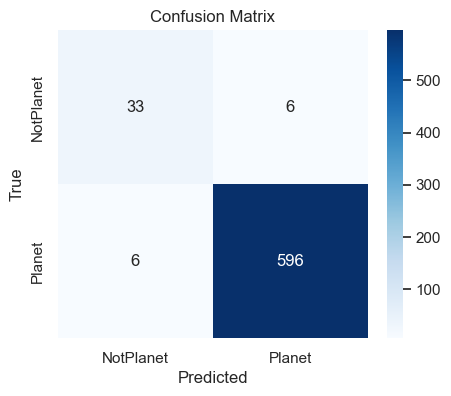

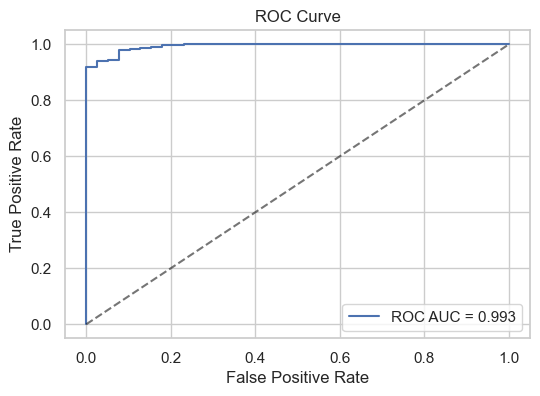

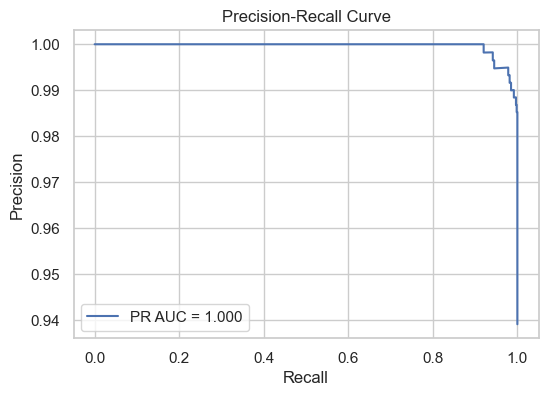

In [86]:
# ## 10) Evaluate on test set using the best estimator

best_pipeline = rnd_search.best_estimator_

# Predictions
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba) if len(np.unique(y_test)) > 1 else np.nan

precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Test PR AUC: {pr_auc:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NotPlanet','Planet'], yticklabels=['NotPlanet','Planet'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'k--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# PR curve
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [87]:
# ## 11) Save final model pipeline to `model.pkl`
# This pipeline includes preprocessing, SMOTE, and classifier. Save with joblib.

MODEL_PATH = "model.pkl"
joblib.dump(best_pipeline, MODEL_PATH)
print(f"Saved model pipeline to {MODEL_PATH}")

Saved model pipeline to model.pkl


In [88]:
# ## 12) Demonstration: load `model.pkl` and predict on new data or held-out test rows
# We'll load the saved model and show a few example predictions from the test set.
# Load
loaded = joblib.load(MODEL_PATH)
print("Loaded model:", type(loaded))

# Predict on 5 test examples
X_test_sample = X_test.head(5)
preds = loaded.predict(X_test_sample)
probs = loaded.predict_proba(X_test_sample)[:, 1]
display_df = X_test_sample.copy()
display_df['pred'] = preds
display_df['prob'] = np.round(probs, 4)
display_df['true'] = y_test[:5]
display(display_df)

Loaded model: <class 'imblearn.pipeline.Pipeline'>


default_flag  sy_snum  sy_pnum discoverymethod  disc_year disc_facility  \
1562             0        1        1         Transit       2018            K2   
2240             1        1        3         Transit       2015            K2   
304              1        1        0         Transit       2016            K2   
2280             1        1        1         Transit       2020            K2   
1414             0        1        6         Transit       2017            K2   

                  soltype  pl_controv_flag  pl_orbper  pl_orbpererr1  ...  \
1562  Published Candidate                0  19.564000       0.001400  ...   
2240  Published Confirmed                0  44.556030       0.000130  ...   
304   Published Candidate                0   0.898344       0.000014  ...   
2280  Published Confirmed                0  26.680000       0.002000  ...   
1414  Published Confirmed                0  12.757590       0.000920  ...   

      sy_kmagerr2  sy_gaiamag  sy_gaiamagerr1  sy_gaiamagerr2   rowupdate  \
1562       -0.017     12.0082        0.000186       -0.000186  2016-07-18   
2240       -0.023     11.4785        0.000959       -0.000959  2023-07-10   
304        -0.031     14.6651        0.001354       -0.001354  2019-09-05   
2280       -0.025     11.9397        0.000259       -0.000259  2020-09-09   
1414       -0.021     12.0252        0.000364       -0.000364  2021-03-12   

      pl_pubdate          releasedate  pred    prob  true  
1562     2016-09           2016-07-18     1  0.9700     1  
2240     2022-11           2023-07-10     1  1.0000     1  
304      2019-09           2019-09-05     1  0.8960     1  
2280     2020-12  2020-09-09 17:05:58     1  0.9683     1  
1414     2018-02           2018-01-11     1  0.9967     1  

[5 rows x 90 columns]

In [89]:
# ## 13) Helper: function to predict on a new CSV (same columns expected)
# This cell demonstrates how you would accept a new CSV uploaded by a user and return predictions.

def predict_from_csv(csv_path, model_path="model.pkl"):
    """
    Loads model pipeline and makes binary predictions on the CSV file.
    Assumes CSV has the same feature columns as the training data (or a superset).
    Returns a DataFrame with predictions and probabilities appended.
    """
    m = joblib.load(model_path)
    new_df = pd.read_csv(csv_path)
    # keep only features used during training; ignore others
    X_new = new_df[features].copy()
    preds = m.predict(X_new)
    probs = m.predict_proba(X_new)[:, 1]
    new_df['pred_exoplanet'] = preds
    new_df['prob_exoplanet'] = probs
    return new_df


In [91]:

# Example usage (uncomment to run):
result_df = predict_from_csv("test.csv", model_path=MODEL_PATH)
result_df.head()



pl_name        hostname  default_flag disposition  \
0        BD+20 594 b       BD+20 594             0   CONFIRMED   
1        BD+20 594 b       BD+20 594             0   CONFIRMED   
2        BD+20 594 b       BD+20 594             1   CONFIRMED   
3  EPIC 201111557.01  EPIC 201111557             1   CANDIDATE   
4  EPIC 201111557.01  EPIC 201111557             0   CANDIDATE   

             disp_refname  sy_snum  sy_pnum discoverymethod  disc_year  \
0    Espinoza et al. 2016        1        1         Transit       2016   
1    Espinoza et al. 2016        1        1         Transit       2016   
2    Espinoza et al. 2016        1        1         Transit       2016   
3  Livingston et al. 2018        1        0         Transit       2018   
4  Livingston et al. 2018        1        0         Transit       2018   

  disc_facility  ... sy_kmagerr1  sy_kmagerr2 sy_gaiamag  sy_gaiamagerr1  \
0            K2  ...       0.018       -0.018    10.8644        0.000249   
1            K2  ...       0.018       -0.018    10.8644        0.000249   
2            K2  ...       0.018       -0.018    10.8644        0.000249   
3            K2  ...       0.019       -0.019    11.3995        0.001307   
4            K2  ...       0.019       -0.019    11.3995        0.001307   

   sy_gaiamagerr2   rowupdate  pl_pubdate  releasedate  pred_exoplanet  \
0       -0.000249  2018-04-25     2018-03   2018-02-15               1   
1       -0.000249  2018-04-25     2016-10   2016-07-28               1   
2       -0.000249  2018-04-25     2017-03   2018-04-26               1   
3       -0.001307  2018-08-02     2018-08   2018-08-02               1   
4       -0.001307  2018-02-15     2018-03   2018-02-15               1   

   prob_exoplanet  
0        0.980000  
1        0.970000  
2        0.946667  
3        0.716667  
4        0.865000  

[5 rows x 96 columns]


### 15) Final notes & recommended next steps
### - **Label mapping**: If you want only `CONFIRMED` to be positive (and `CANDIDATE` -> negative), change `is_positive_disposition()` accordingly.
### - **Feature engineering**: Consider adding domain features (e.g., `log(period)`, `depth / duration` ratios) if those columns exist.
### - **Model choices**: If you prefer XGBoost/LightGBM, replace `RandomForestClassifier` with `XGBClassifier` or `LGBMClassifier` in the pipeline — the rest of the pipeline remains compatible.
### - **SHAP**: For explainability add SHAP analysis to show per-prediction feature contributions.
### - **Production**: For production-ready FastAPI, add validation, schema checks for incoming CSVs, rate-limiting, and unit tests.
